In [1]:
import os
from datetime import datetime
import shutil
from time import time
import numpy as np
from tqdm import tqdm
from math import *
import threading
import queue
import linecache

In [2]:
class myThread (threading.Thread):
    def __init__(self, threadID, name, table, first_page, last_page, fields_to_sum, q):
        '''
        To initialize a new thread that will run the aggragation sum, we need to set the parameters :
        - threadID (int): a unique identifier 
        - name (str)
        - table (class Table) : the table the thread will work on
        - first_page, last_page (int) : the thread will work on the table's pages betwenn first_page and last_page
        - fields_to_sum (list) : list of the table's fields we want to sum
        - q (queue) : the queue in which we will store the results of the sum
        '''
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.first_page = first_page
        self.last_page = last_page
        self.table = table
        self.fields_to_sum = fields_to_sum
        self.q = q
    
    def run(self):
        '''
        Function that will be launched when we will do 'thread.start()'
        It will launch the function calcul_sum_thread, that will calculate the sum of the table's fields in the corresponding range of pages
        '''
        print("Starting " + self.name + '\n')
        res = self.table.calcul_sum_thread(self.name, self.fields_to_sum, self.first_page, self.last_page, self.q)
        return res

In [3]:
SCHEMAS = {'part': ['P_PARTKEY', 'P_NAME', 'P_MFGR',
                  'P_BRAND', 'P_TYPE', 'P_SIZE', 
                  'P_CONTAINER', 'P_RETAILPRICE', 'P_COMMENT'],
         'supplier': ['S_SUPPKEY', 'S_NAME', 'S_ADDRESS',
                      'S_NATIONKEY', 'S_PHONE', 'S_ACCTBAL',
                      'S_COMMENT'],
         'partsupp': ['PS_PARTKEY', 'PS_SUPPKEY', 'PS_AVAILQTY',
                      'PS_SUPPLYCOST', 'PS_COMMENT'],
         'customer': ['C_CUSTKEY', 'C_NAME', 'C_ADDRESS',
                      'C_NATIONKEY', 'C_PHONE', 'C_ACCTBAL',
                      'C_MKTSEGMENT', 'C_COMMENT'],
         'orders': ['O_ORDERKEY', 'O_CUSTKEY', 'O_ORDERSTATUS',
                   'O_TOTALPRICE', 'O_ORDERDATE', 'O_ORDERPRIORITY',
                   'O_CLERK', 'O_SHIPPRIORITY', 'O_COMMENT'],
         'lineitem': ['L_ORDERKEY', 'L_PARTKEY', 'L_SUPPKEY',
                      'L_LINENUMBER', 'L_QUANTITY', 'L_EXTENDERDPRICE',
                      'L_DISCOUNT', 'L_TAX', 'L_RETRUNFLAG',
                      'L_LINESTATUS', 'L_SHIPDATE', 'L_COMMITDATE',
                      'L_RECEIPTDATE', 'L_SHIPINSTRUCT', 'L_SHIPMODE',
                      'L_COMMENT'],
         'nation': ['N_NATIONKEY', 'N_NAME', 'N_REGIONKEY', 'N_COMMENT'],
         'region': ['R_REGIONKEY', 'R_NAME', 'R_COMMENT']}

PAGE_LENGTH = 50000

In [4]:
# Comparison operators
def is_equal(x, y):
    return x == y

def is_inferior(x, y):
    return x < y

def is_superior(x, y):
    return x > y

def is_inferior_equal(x, y):
    return x <= y

def is_superior_equal(x, y):
    return x >= y

dico_operator = {'=' : is_equal,
                 '>': is_superior,
                 '>=': is_superior_equal,
                 '<': is_inferior,
                 '<=': is_inferior_equal}

In [5]:
# Les hash functions retenues, modifiables

def hash_function(x, number_bucket=300):
    try:
        x = int(x)
        return x % number_bucket

    except:
        return str(x)[0]

In [6]:
ERROR_MODE_TABLE = 'The table is not in the correct mode'
READ_MODE = ['r']
WRITE_MODE = ['w', 'a', 'w+', 'r+']

class Table:
    
    def __init__(self, name, path='', fields=None, new_file=False):
        
        self.name = name
        self.path_file = os.path.join(path, name+'.txt')
        self.path_index = os.path.join(path, name+'_index.txt')
      
        self.fields = fields if fields else SCHEMAS[name]
        
        # Write the schema if the file is empty or it is a new file
        if new_file or not(os.path.isfile(self.path_file)) or (os.path.getsize(self.path_file) == 0):
            self.file = open(self.path_file, 'w')
            self.file.write('|'.join(self.fields) + '\n')
        
        self.page_num = 1   # First page is for the schema
        self.offset = 0
        self.last_page_data = ''
        self.last_page_len = 0
    
    #------------------------
    #       UTILITIES
    #------------------------

    def open_table(self, mode):
        ''' Open the table and its index in the specified mode

        Inputs:
          mode (str) : the mode to open the file ('w', 'r', 'a', 'w+')
        '''

        self.file = open(self.path_file, mode)
        self.index = open(self.path_index, mode)
        self.mode = mode
        
    def close_table(self):
        ''' Close the table and its index and add remaning data to table
        '''

        # Before closing if the mode in write we append the data left in object
        if self.mode in WRITE_MODE:
            self.file.write(self.last_page_data)
            self.last_page_data = ''
        
        # And close everything
        self.file.close()
        self.index.close()
    
    def write(self, data, data_id):
        ''' Central fonction that write to table with the record/page paradigme

        Inputs: 
          data (str) : data to add to the table, should be :
                       'field|field|...|field@field|...|field@'
          data_id (str) : the unique id of the data that will be put in the index
                          if None, no index is added
        ''' 
        # Verify that the table is in correct mode
        assert self.mode in WRITE_MODE, ERROR_MODE_TABLE

        len_data = len(data)        
        # If there is more space push the data onto the page
        if self.last_page_len + len_data < PAGE_LENGTH:
            self.last_page_data += data
            self.last_page_len += len_data

        # Else append the data to the file
        else:
            if self.mode in ['w+', 'r+']:
                try:
                    self.file.seek(-1)    # Go to the end of the file
                except ValueError:
                    pass
            self.file.write(self.last_page_data + '\n')
            self.last_page_data = data
            self.last_page_len = len_data
            self.page_num += 1
            self.offset = 0
        
        if data_id:
            # Write the index of the file
            self.index.write(f'{data_id}|{self.page_num}|{self.offset}\n')
            self.offset += 1

            
    def get_by_id(self, record_id):
        ''' Retrun a record based on its id using the index

        Input:
          record_id (str): the unique id of the record
        
        Output:
          (Table) : the record
        '''

        # Open the table and create output
        self.open_table('r')
        output = Table('output', '', self.fields, new_file=True)
        output.open_table('a')
        
        # Transorm the id into a string as it is the format of the read
        record_id_str = str(record_id) + '|'
        record_id_size = len(record_id_str)
                                      
        # Compare the first characters of each line of the index with the id
        for line in self.index:
            if line[:record_id_size] == record_id_str:
                line = line.split('|')
                page_id, offset = int(line[1]), int(line[2])

        # Read file until the right page and get the record with the offset
        for i, line in enumerate(self.file):
            if i == page_id:
                result = line.strip().split('@')[offset]
                output.write(result + '@', result.split('|')[0])
                break
                
        # Close the tables
        output.close_table()
        self.close_table()
        
        return output
    
    def print_table(self, number_pages=1):
        ''' Print the table beautifully to '{name}_nice.txt'

        Input:
          number_pages (int): the number of the table pages that should be printed
        '''
        
        self.open_table('r')
        self.file.readline()
        
        list_max_size = [len(field)+4 for field in self.fields]
        
        for i, page in enumerate(self.file):
            if i < number_pages:
                results = [record.split('|') for record in page.split('@')[:-1]]
                tmp_lst_max_size = [max([len(record[i]) for record in results])+4 for i in range(len(self.fields))]
                list_max_size = [max(maxi, maxi_tmp) for (maxi, maxi_tmp) in zip(list_max_size, tmp_lst_max_size)]
            else:
                break
                
        self.close_table()
        self.open_table('r')
        
        with open(f'{self.name}_nice.txt', 'w') as nice:
            
            str_schema = [f'{value:^{offset}}' for value, offset in zip(self.fields, list_max_size)]
            nice.write(' ' + '│ '.join(str_schema))
            nice.write('\n─' + '┼─'.join(['─'*field_len for field_len in list_max_size]) + '\n')
            
            for i, page in enumerate(self.file):
                if i-1 < number_pages:
                    if i-1 > 0:
                        nice.write('\n')
                        
                    line = [[f'{value:<{offset}}' for value, offset in zip(record.split('|'), list_max_size)]
                                                                                for record in page.split('@')[:-1]]
                    nice.write('\n'.join([' ' + '│ '.join(record) for record in line]))
                else:
                    break
                    
        self.close_table()
        
    def fields2id(self, list_field_name):
        '''Gives the position of field in the table schema

        Input:
            list_fields_name (lst [str]) : a list of fields name
        Ouptut:
            (lst [int]) : position of each fields
        '''
        list_field_id = []
        for name in list_field_name:
            i = 0
            while self.fields[i] != name:
                i += 1
            list_field_id.append(i)
            
        return list_field_id
    
    #------------------------
    #       SELECTION
    #------------------------

    def selection(self, field_name, operator, value, output_name='output', output_path=''):
        '''Select records based on a condition on a field

        Inputs:
          field_name (str) : the fileld on which we will check the condition
          operator (str) : the operator used for the condition (must be in dict_operator keys)
          value (int/str) : the value to compare the field
          output_name (str) : the name of the output file
          output_path (str) : the path of the output file

        Output:
          (Table) : containing all records from the table that verifies the condition
        '''
        
        # Save the time of the selection
        t0 = time()
        
        # Set the comparaison
        comparaison = dico_operator[operator]
        
        # The comparaison type : str or int
        type_compare = type(value)

        # Open the table and the output
        self.open_table('r')
        output = Table(output_name, output_path, self.fields, new_file=True)
        output.open_table('a') 
            
        # Turn the field name into field id
        field_id = self.fields2id([field_name])[0]
        
        # Skip the first page as it is schema
        self.file.readline()

        for page in self.file:
            for record in page.strip().split('@')[:-1]:
                
                fields = record.split('|')

                # Compare the attribut and the value
                if comparaison(type_compare(fields[field_id]), value):
                    output.write(record + '@', record.split('|')[0])

        t1 = time()
        T = t1 - t0
        print(f'The selection took {T:.4f}s')
        
        output.close_table()
        self.close_table()
        
        return output

    #------------------------
    #       PROJECTION
    #------------------------

    def projection(self, fields_project, field_hash, output_name='output', output_path=''):
        '''Project selected fields and use hash to speed duplicate suppression

        Inputs:
          field_project (lst [str]) : the fileld names to project
          field_hash (int) : the position in field_project of the field on which to apply the hash
          output_name (str) : the name of the output file
          output_path (str) : the path of the output file

        Output:
          (Table) : containing all fields from the table without duplicate
        '''
        
        # Creation of the repo data/buckets/buckets_date_hour where we will save the different buckets
        # We will supress this repo at the end of the method
        t0 = time()
        now = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

        buckets_path = os.path.join('data', 'buckets', f'buckets_{now}')
        os.mkdir(buckets_path)
        
        # Get the id and the name of fields selected in the right order
        fields_id = self.fields2id(fields_project)

        # Open the table and the output
        self.open_table('r')
        output = Table(output_name, output_path, fields_project, new_file=True)
        output.open_table('a')

        # dict of bucket table
        buckets_dict = {}
        
        # Skip the first line bc it correspond to the schema
        self.file.readline()
        
        for page in tqdm(self.file):
            for record in page.strip().split('@')[:-1]:
                fields = record.split('|')
                attributs = [fields[i] for i in fields_id]
                attributs_str = '|'.join(attributs)

                hash_value = hash_function(attributs[field_hash])
                bucket_path = os.path.join(buckets_path, f'bucket_{hash_value}.txt')

                # If the bucket don't already exist we create it, store the record and add to the output
                if not(hash_value in buckets_dict.keys()):
                    bucket = Table(f'bucket_{hash_value}', buckets_path, fields=[''])
                    buckets_dict[hash_value] = bucket

                    bucket.open_table('w+')                   # Open the file in write/read mode

                    bucket.write(attributs_str + '@', None)   # Write the new value in the bucket
                    output.write(attributs_str + '@', None)   # Write on the output
                    
                # Else we compare only with the good bucket's records and add to 
                # the bucket and the output if not present
                else:
                    bucket = buckets_dict[hash_value]
                    bucket.file.seek(0)   # Go back at the begining of the file
                    
                    new_record = True
                    for page in bucket.file:
                        if attributs_str in page.strip().split('@')[:-1]:
                            new_record = False
                            break
                            
                    if new_record:
                        bucket.write(attributs_str + '@', None)   # Write the new value in the bucket
                        output.write(attributs_str + '@', None)   # Write on the output
        
        # We close all bucket file before deleting them
        for key in buckets_dict:
            buckets_dict[key].close_table()
        shutil.rmtree(buckets_path)

        t1 = time()
        T = t1 - t0
        
        print(f'The projection took {T:.4f}s')
        
        output.close_table()
        self.close_table()

        return output

    #------------------------
    #          SUM
    #------------------------

    def aggregate_sum(self, fields_to_sum, output_name='output', output_path=''):
        '''Add the fields selected of each record from the table

        Inputs:
            fields_to_sum (lst [str]) : a list of field names to add (fields must be numerical)
            output_name (str) : the name of the output file
            output_path (str) : the path of the output file
        
        Output:
          (Table) : results for each field
        '''

        sum_fields = [0]*len(fields_to_sum)
        fields_id = self.fields2id(fields_to_sum)
        
        # Open the table and the output
        self.open_table('r')
        
        for page in self.file:
            for record in page.strip().split('@')[:-1]:
                attributs = record.split('|')
                attributs = [attributs[i] for i in fields_id]
                
                sum_fields = [s + float(attribut) for (s, attribut) in zip(sum_fields, attributs)]
        
        output = Table(output_name, output_path, fields_to_sum, new_file=True)
        output.open_table('a')
        
        output.write('|'.join([str(s) for s in sum_fields]) + '@', None)
        
        output.close_table()
        self.close_table()
        
        return output
    
    #------------------------
    #      GROUP BY
    #------------------------
        
    def group_by(self, field_group_by, output_name='results_group_by'):

        '''Group records in tables based on the value of a field

        Inputs:
            field_group_by (str): the field used to group record
            output_name (str): the output directory name
        '''
        
        results_path = 'results_group_by'
        try:
            os.mkdir(results_path)
        except FileExistsError:
            pass
        
        results_dir = {}

        field_selection = self.fields2id([field_group_by])[0]

        self.open_table('r')
        self.file.readline()    # skip the first line
        
        for page in tqdm(self.file):
            for record in page.split('@')[:-1]:
                
                attributs = [attr for attr in record.split('|')]                
                value = attributs[field_selection]
                
                # If the value of the field has not been yet recorded, then we create a new table which will correpond to this new value
    
                if not(value in results_dir.keys()):
                    
                    results_dir[value] = Table(f'result_{value}', results_path, self.fields)
                    result = results_dir[value]
                    result.open_table('a')
                    result.write(record + '@', None)
                    result.close_table()
                    
                # If the value of the field has already been recorded, then we add it to its corresponding table
                
                else:
                    
                    result = results_dir[value]
                    result.open_table('a')
                    result.write(record + '@', None)
                    result.close_table()
        
        self.close_table()

    #------------------------
    #         JOIN
    #------------------------

    def nested_loop_join(self, inner_table, field_selection_outer, field_selection_inner, output_name = 'output', output_path = ''):
        ''' Cartesian product of two tables based on a similar field. For this we don't use hashing.

        Inputs:
            inner_table (Table) : the second table
            field_selection_outer : the selection field in this table
            field_selection_inner : the selection field in the other table
            output_name (str) : the name of the output file
            output_path (str) : the path of the output file

        Output:
          (Table) : the join table base on the selection field
        '''
        
        t0 = time()
        
        self.open_table('r')
        inner_table.open_table('r')
        
        field_selection_outer = self.fields2id([field_selection_outer])[0]
        field_selection_inner = inner_table.fields2id([field_selection_inner])[0]
        
        output = Table(output_name, output_path, self.fields + inner_table.fields , new_file=True)
        output.open_table('a')
        
        
        for page_outer in tqdm(self.file):
            for record_outer in page_outer.split('@')[:-1]:
                
                fields_outer = record_outer.split('|')

                inner_table.file.seek(0)
                inner_table.file.readline() # skip the fields row

                for page_inner in inner_table.file :
                    for record_inner in page_inner.split('@')[:-1]:
                        fields_inner = record_inner.split('|')

                        if fields_outer[field_selection_outer] == fields_inner[field_selection_inner]:
                            output.write(record_outer + '|' + record_inner + '@', fields_outer[0])
        
        t1 = time()
        T = t1-t0
        
        print(f'The join (using the nested loop method) took {T:.4f}s')
        
        output.close_table()
        inner_table.close_table()
        self.close_table()
        
        return output
    
    
    def hash_join(self, inner_table, field_selection_outer, field_selection_inner, output_name = 'output', output_path = ''):
        ''' Cartesian product of two tables based on a similar field. For this we use hashing.

        Inputs:
            inner_table (Table) : the second table
            field_selection_outer : the selection field in this table
            field_selection_inner : the selection field in the other table
            output_name (str) : the name of the output file
            output_path (str) : the path of the output file

        Output:
          (Table) : the join table base on the selection field
        '''

        t0 = time()
        
        now = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    
        buckets_inner_path = os.path.join('data', 'buckets_inner_'+ f'{now}')
        os.mkdir(buckets_inner_path)
   
        buckets_inner_dict = {}
                 
        # Partition of the inner table
     
        inner_table.open_table('r')
        field_selection_inner = inner_table.fields2id([field_selection_inner])[0]
     
        for page in tqdm(inner_table.file):

            for record in page.strip().split('@')[:-1]:
                fields = record.split('|')
                
                hash_value = hash_function(fields[field_selection_inner])
                bucket_inner_path = os.path.join(buckets_inner_path, f'bucket_{hash_value}.txt')
                
                # If the bucket does not exist we create a new bucket and add the tuple to this bucket
                
                if not(hash_value in buckets_inner_dict.keys()):
                    buckets_inner_dict[hash_value] = Table(f'bucket_{hash_value}', buckets_inner_path, fields=[''])
                    
                    bucket = buckets_inner_dict[hash_value]
                    bucket.open_table('w+')
                    bucket.write(record + '@', None)
                    
                else:
                    bucket = buckets_inner_dict[hash_value]
                    bucket.write(record + '@', None)
        
        # Write the remaining data
        for key in buckets_inner_dict.keys():
            buckets_inner_dict[key].close_table()
            
        output = Table(output_name, output_path, self.fields + inner_table.fields, new_file=True)
        output.open_table('a')
        
        # To read and write
        for key in buckets_inner_dict.keys():
            buckets_inner_dict[key].open_table('r+')   # w+ delets the file
        
        self.open_table('r')
        self.file.readline()  # skip the first line
        
        field_selection_outer = self.fields2id([field_selection_outer])[0]
        
        for page_outer in tqdm(self.file):
            for record_outer in page_outer.split('@')[:-1]:
                fields_outer = record_outer.split('|')

                hash_value = hash_function(fields_outer[field_selection_outer])
                
                # If the hash value does not exist we don't even need to check
                try:
                    bucket_inner = buckets_inner_dict[hash_value]
                except KeyError:
                    break
                    
                # Select the correct bucket
                bucket_inner.file.seek(0)   # Go to the start of the bucket

                # Check in the bucket if a record correspond if so write it in output
                for page_inner in bucket_inner.file:
                    for record_inner in page_inner.split('@')[:-1]:
                        fields_inner = record_inner.split('|')

                        if fields_outer[field_selection_outer] == fields_inner[field_selection_inner]:
                            output.write(record_outer + '|' + record_inner + '@', fields_outer[0])
            
        t1 = time()
        T = t1-t0

        shutil.rmtree(buckets_inner_path)   #to supress the created bucket that takes places on the disk
    
        print(f'The join (using the hash method) took {T:.4f}s')
        
        self.close_table()
        inner_table.close_table()
        output.close_table()
        
        return output

    #------------------------
    #      MULTI-THREAD
    #------------------------

    def calcul_sum_thread(self, threadName, fields_to_sum, first_page, last_page, q):
        '''
        Make a certain thread calculating the intermediate sum between two specific pages

        Parameters
        -------------------------
        threadName (str) : the name of the thread that will executes the function
        fields_to_sum (list) : the list of the table's fields we want to sum
        first_page, last_page (int): the first and the last pages the thread will work on
        q (queue) : the queue used to store the results of the sum
        '''
        self.open_table('r')
        sum_fields = [0]*len(fields_to_sum)
        fields_id = self.fields2id(fields_to_sum)
        
        # For each page between first_page and last_page, we calculate the sum of fields_to_sum
        for index_page in range(first_page, last_page):
            page = linecache.getline(self.path_file, index_page+1)
            for record in page.strip().split('@')[:-1]:
                attributs = record.split('|')
                attributs = [attributs[i] for i in fields_id]

                sum_fields = [s + float(attribut) for (s, attribut) in zip(sum_fields, attributs)]
        q.put(np.array(sum_fields))

    def aggregate_sum_mthread(self, fields_to_sum, n_thread, output_name='output', output_path=''):
        '''
        Separate the task between the n_thread threads and aggregate the intermediate results
        '''
        t0 = time()
        q = queue.Queue()
        self.open_table('r')
        n_line = sum(1 for line in self.file)
        step = ceil((n_line) / n_thread)

        # We divide the number of pages equelly between the threads
        for i in range(n_thread):
            thread = myThread(i, f"Thread-{i+1}", self, i*step, min(n_line+1, (i+1)*step), fields_to_sum, q)
            thread.start()
            
        # The intermediate sums are stored in the queue q, we sum these results to get the final sum
        sum_fields = np.array([0.]*len(fields_to_sum))
        for i in range(n_thread):
            sum_fields += q.get() 
        print(sum_fields)
        
        # We store the final sum in the file output_path/output_name
        output = Table(output_name, output_path, fields_to_sum, new_file=True)
        output.open_table('a')
        output.write('|'.join([str(s) for s in sum_fields]) + '@', None)
        output.close_table()
        t1 = time()
        T = t1-t0
        
        print(f'The sum took {T:.4f}s')

    #-------------------
    #     Mesures
    #-------------------
    
    def nested_loop_join_timed(self, inner_table, field_selection_outer, field_selection_inner, time_limit=10, output_name = 'output', output_path = ''):
        ''' Cartesian product of two tables based on a similar field. For this we don't use hashing.

        Inputs:
            inner_table (Table) : the second table
            field_selection_outer : the selection field in this table
            field_selection_inner : the selection field in the other table
            output_name (str) : the name of the output file
            output_path (str) : the path of the output file

        Output:
          (Table) : the join table base on the selection field
        '''
        
        t0 = time()
        
        self.open_table('r')
        inner_table.open_table('r')
        
        field_selection_outer = self.fields2id([field_selection_outer])[0]
        field_selection_inner = inner_table.fields2id([field_selection_inner])[0]
        
        output = Table(output_name, output_path, self.fields + inner_table.fields , new_file=True)
        output.open_table('a')
        
        
        for i, page_outer in tqdm(enumerate(self.file)):
            for record_outer in page_outer.split('@')[:-1]:
                
                fields_outer = record_outer.split('|')

                inner_table.file.seek(0)
                inner_table.file.readline() # skip the fields row

                for page_inner in inner_table.file :
                    for record_inner in page_inner.split('@')[:-1]:
                        fields_inner = record_inner.split('|')

                        if fields_outer[field_selection_outer] == fields_inner[field_selection_inner]:
                            output.write(record_outer + '|' + record_inner + '@', fields_outer[0])
        
            t1 = time()
            T = t1-t0
            if T > time_limit:
                break
        
        print(f'The join (using the nested loop method) took {T:.4f}s')
        
        output.close_table()
        inner_table.close_table()
        self.close_table()
        
        return i, T
    
      
    def hash_join_timed(self, inner_table, field_selection_outer, field_selection_inner, time_limit, output_name = 'output', output_path = ''):
        ''' Cartesian product of two tables based on a similar field. For this we use hashing.

        Inputs:
            inner_table (Table) : the second table
            field_selection_outer : the selection field in this table
            field_selection_inner : the selection field in the other table
            output_name (str) : the name of the output file
            output_path (str) : the path of the output file

        Output:
          (Table) : the join table base on the selection field
        '''

        t0 = time()
        
        now = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    
        buckets_inner_path = os.path.join('data', 'buckets_inner_'+ f'{now}')
        os.mkdir(buckets_inner_path)
   
        buckets_inner_dict = {}
                 
        # Partition of the inner table
     
        inner_table.open_table('r')
        field_selection_inner = inner_table.fields2id([field_selection_inner])[0]
     
        for page in tqdm(inner_table.file):

            for record in page.strip().split('@')[:-1]:
                fields = record.split('|')
                
                hash_value = hash_function(fields[field_selection_inner])
                bucket_inner_path = os.path.join(buckets_inner_path, f'bucket_{hash_value}.txt')
                
                # If the bucket does not exist we create a new bucket and add the tuple to this bucket
                
                if not(hash_value in buckets_inner_dict.keys()):
                    buckets_inner_dict[hash_value] = Table(f'bucket_{hash_value}', buckets_inner_path, fields=[''])
                    
                    bucket = buckets_inner_dict[hash_value]
                    bucket.open_table('w+')
                    bucket.write(record + '@', None)
                    
                else:
                    bucket = buckets_inner_dict[hash_value]
                    bucket.write(record + '@', None)
        
        # Write the remaining data
        for key in buckets_inner_dict.keys():
            buckets_inner_dict[key].close_table()
        
        t_hash = time()
        
        output = Table(output_name, output_path, self.fields + inner_table.fields, new_file=True)
        output.open_table('a')
        
        # To read and write
        for key in buckets_inner_dict.keys():
            buckets_inner_dict[key].open_table('r+')   # w+ delets the file
        
        self.open_table('r')
        self.file.readline()  # skip the first line
        
        field_selection_outer = self.fields2id([field_selection_outer])[0]
        
        for i, page_outer in tqdm(enumerate(self.file)):
            for record_outer in page_outer.split('@')[:-1]:
                fields_outer = record_outer.split('|')

                hash_value = hash_function(fields_outer[field_selection_outer])
                
                # If the hash value does not exist we don't even need to check
                try:
                    bucket_inner = buckets_inner_dict[hash_value]
                except KeyError:
                    break
                    
                # Select the correct bucket
                bucket_inner.file.seek(0)   # Go to the start of the bucket

                # Check in the bucket if a record correspond if so write it in output
                for page_inner in bucket_inner.file:
                    for record_inner in page_inner.split('@')[:-1]:
                        fields_inner = record_inner.split('|')

                        if fields_outer[field_selection_outer] == fields_inner[field_selection_inner]:
                            output.write(record_outer + '|' + record_inner + '@', fields_outer[0])
            
                t1 = time()
                T = t1-t0
                
                if T > time_limit:
                    break
            
            if T > time_limit:
                break

        shutil.rmtree(buckets_inner_path)   #to supress the created bucket that takes places on the disk
    
        print(f'The join (using the hash method) took {T:.4f}s')
        
        self.close_table()
        inner_table.close_table()
        output.close_table()
        
        return i, t1 - t0, t_hash - t0
    
    def projection_timed(self, fields_project, field_hash, time_limit, output_name='output', output_path=''):
        '''Project selected fields and use hash to speed duplicate suppression

        Inputs:
          field_project (lst [str]) : the fileld names to project
          field_hash (int) : the position in field_project of the field on which to apply the hash
          output_name (str) : the name of the output file
          output_path (str) : the path of the output file

        Output:
          (Table) : containing all fields from the table without duplicate
        '''
        
        # Creation of the repo data/buckets/buckets_date_hour where we will save the different buckets
        # We will supress this repo at the end of the method
        t0 = time()
        now = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

        buckets_path = os.path.join('data', 'buckets', f'buckets_{now}')
        os.mkdir(buckets_path)
        
        # Get the id and the name of fields selected in the right order
        fields_id = self.fields2id(fields_project)

        # Open the table and the output
        self.open_table('r')
        output = Table(output_name, output_path, fields_project, new_file=True)
        output.open_table('a')

        # dict of bucket table
        buckets_dict = {}
        
        # Skip the first line bc it correspond to the schema
        self.file.readline()
        
        for i, page in tqdm(enumerate(self.file)):
            for record in page.strip().split('@')[:-1]:
                fields = record.split('|')
                attributs = [fields[i] for i in fields_id]
                attributs_str = '|'.join(attributs)

                hash_value = hash_function(attributs[field_hash])
                bucket_path = os.path.join(buckets_path, f'bucket_{hash_value}.txt')

                # If the bucket don't already exist we create it, store the record and add to the output
                if not(hash_value in buckets_dict.keys()):
                    bucket = Table(f'bucket_{hash_value}', buckets_path, fields=[''])
                    buckets_dict[hash_value] = bucket

                    bucket.open_table('w+')                   # Open the file in write/read mode

                    bucket.write(attributs_str + '@', None)   # Write the new value in the bucket
                    output.write(attributs_str + '@', None)   # Write on the output
                    
                # Else we compare only with the good bucket's records and add to 
                # the bucket and the output if not present
                else:
                    bucket = buckets_dict[hash_value]
                    bucket.file.seek(0)   # Go back at the begining of the file
                    
                    new_record = True
                    for page in bucket.file:
                        if attributs_str in page.strip().split('@')[:-1]:
                            new_record = False
                            break
                            
                    if new_record:
                        bucket.write(attributs_str + '@', None)   # Write the new value in the bucket
                        output.write(attributs_str + '@', None)   # Write on the output
            
                t1 = time()
                if t1 - t0 > time_limit:
                    break
              
            if t1 - t0 > time_limit:
                    break
            
        # We close all bucket file before deleting them
        for key in buckets_dict:
            buckets_dict[key].close_table()
        shutil.rmtree(buckets_path)

        print(f'The projection took {t1 - t0:.4f}s')
        
        output.close_table()
        self.close_table()

        return i

    # Cette fonction est utilisée par Carlos pour la comparaison des row et colonne 
    def projection_car(self, fields_project, field_hash, duplicates_elimination=True, number_bucket=10, output_name='output', output_path=''):
        '''
        save the results of the projection on fields 'fields_project' on the file output_path/output_name.txt        
        '''
        
        # Creation of the repo data/buckets/buckets_date_hour where we will save the different buckets
        # We will supress this repo at the end of the method
        t0 = time()
        now = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        cpteur = 0
        cpteur_duplicates = 0

        buckets_path = os.path.join('data', 'buckets', f'buckets_{now}')
        os.mkdir(buckets_path)
        
        # Get the id and the name of fields selected in the right order
        fields_id = self.fields2id(fields_project)

        # Open the table and the output
        self.open_table('r')
        output = Table(output_name, output_path, fields_project, new_file=True)
        output.open_table('a')

        # dict of bucket table
        buckets_dict = {}
        
        # Skip the first line bc it correspond to the schema
        self.file.readline()
        
        for i, page in enumerate(self.file):
            #if i<10:
            if True :
                for record in page.strip().split('@')[:-1]:
                    cpteur +=1
                    fields = record.split('|')
                    attributs = [fields[i] for i in fields_id]
                    attributs_str = '|'.join(attributs)

                    hash_value = hash_function(attributs[field_hash], number_bucket)
                    bucket_path = os.path.join(buckets_path, f'bucket_{hash_value}.txt')

                    if not duplicates_elimination:
                        output.write(attributs_str + '@', None)


                    # If the bucket don't already exist we create it and store the record and add to result
                    elif not(hash_value in buckets_dict.keys()):
                        buckets_dict[hash_value] = Table(f'bucket_{hash_value}', buckets_path, fields=[' '])
                        bucket = buckets_dict[hash_value]
                        bucket.open_table('w')                   # Open the file in write mode
                        bucket.write(attributs_str + '@', None)  # Write the new value in the bucket
                        bucket.close_table()                     # Close the writing process

                        output.write(attributs_str + '@', None)        # Write on the output

                    # Else we compare only with the good bucket's records and add to 
                    # the bucket and the output if not present
                    else:
                        bucket = buckets_dict[hash_value]
                        bucket.open_table('r')

                        new_record = True
                        for page in bucket.file:
                            if attributs_str in page.strip().split('@')[:-1]:
                                #bucket.close_table()                     # Close the reading process
                                new_record = False
                                cpteur_duplicates += 1

                        if new_record:
                            bucket.close_table()                     # Close the reading process
                            bucket.open_table('a')                   # Open the file in append mode
                            bucket.write(attributs_str + '@', None)  # Write the new value in the bucket
                            bucket.close_table()                     # Close the writing process

                            output.write(attributs_str + '@', None)        # Write on the output
        
        print(cpteur, cpteur_duplicates) 
        shutil.rmtree(buckets_path)  #to supress the created bucket that takes places on the disk
        t1 = time()
        T = t1 - t0
        
        print(f'The projection took {T:.4f}s')
        
        output.close_table()
        
        return output

## Queries : *On laisse ? Si oui il faut laisser la partie Mesure de la classe Table si non on peut avoir un code plus propre*

#### Query 1 : Importance of number_bucket 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [8]:
x, y = [], []
for number_bucket in [1, 2, 5, 15, 30, 60, 100]:
    
    def hash_function(x):
        try:
            x = int(x)
            return x % number_bucket
        except:
            return str(x)[0]
        
    orders_tbl = Table('orders', path='data')
    
    x.append(number_bucket)
    nb_pages = orders_tbl.projection_timed(['O_CUSTKEY'], 0, 10)
    y.append(nb_pages)

40it [00:09,  4.03it/s]


The projection took 10.0010s


56it [00:09,  5.60it/s]


The projection took 10.0004s


109it [00:09, 10.90it/s]


The projection took 10.0005s


159it [00:09, 15.91it/s]

The projection took 10.0009s



284it [00:09, 28.44it/s]


The projection took 10.0006s


458it [00:09, 45.85it/s]


The projection took 10.0000s


378it [00:09, 37.81it/s]


The projection took 10.0004s


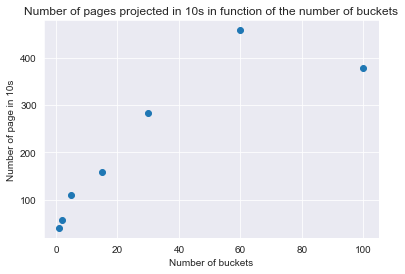

In [9]:
plt.scatter(x, y)
plt.ylabel('Number of page in 10s')
plt.xlabel('Number of buckets')
plt.title('Number of pages projected in 10s in function of the number of buckets')
plt.savefig('fig1.png')
plt.show()

#### Query 2 : Importance of number_buckets in hash join

In [8]:
x, y, lst_time_hash = [], [], []
for number_bucket in [20, 30, 60, 90, 120, 150, 180]:
    
    def hash_function(x):
        try:
            x = int(x)
            return x % number_bucket
        except:
            return str(x)[0]
        
    customer_tbl = Table('customer', 'data')
    orders_tbl = Table('orders', 'data')
    
    x.append(number_bucket)
    nb_pages, _, time_hash = customer_tbl.hash_join_timed(orders_tbl, 'C_CUSTKEY', 'O_CUSTKEY', 20)
    y.append(nb_pages)
    lst_time_hash.append(time_hash)

3415it [00:08, 380.33it/s]
0it [00:11, ?it/s]


The join (using the hash method) took 20.0520s


3415it [00:09, 342.10it/s]
177it [00:10, 17.70it/s]


The join (using the hash method) took 20.0015s


3415it [00:10, 336.44it/s]
342it [00:09, 34.75it/s]


The join (using the hash method) took 20.0293s


3415it [00:10, 317.79it/s]
471it [00:09, 50.97it/s]


The join (using the hash method) took 20.0052s


3415it [00:11, 302.74it/s]
485it [00:07, 65.31it/s]


The join (using the hash method) took 18.7506s


3415it [00:12, 277.55it/s]
485it [00:06, 80.15it/s] 


The join (using the hash method) took 18.4063s


3415it [00:11, 290.18it/s]
485it [00:05, 94.60it/s] 

The join (using the hash method) took 16.9624s


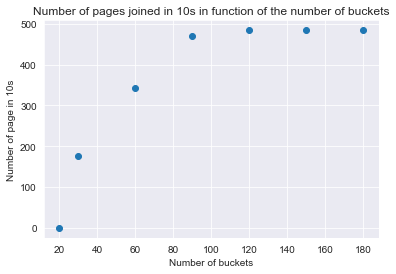

In [9]:
plt.scatter(x, y)
plt.ylabel('Number of page in 10s')
plt.xlabel('Number of buckets')
plt.title('Number of pages joined in 10s in function of the number of buckets')
plt.savefig('fig2.png')
plt.show()

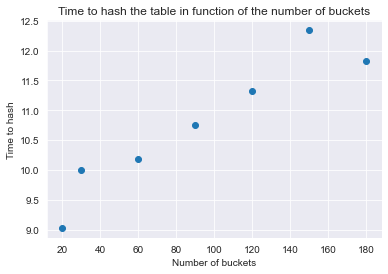

In [10]:
plt.scatter(x, lst_time_hash)
plt.ylabel('Time to hash')
plt.xlabel('Number of buckets')
plt.title('Time to hash the table in function of the number of buckets')
plt.savefig('fig3.png')
plt.show()

#### Query 3 : the importance of hashing for joint operation

In [36]:
name_1 = 'nation'
name_2 = 'supplier'

path = 'data'

nation_tbl = Table(name_1, path)
supplier_tbl = Table(name_2, path)

In [38]:
nation_tbl.nested_loop_join(supplier_tbl, 'N_NATIONKEY', 'S_NATIONKEY').print_table(float('inf'))

2it [00:00,  8.42it/s]

The join (using the nested loop method) took 0.2439s


In [40]:
nation_tbl.hash_join(supplier_tbl, 'N_NATIONKEY', 'S_NATIONKEY').print_table(float('inf'))

30it [00:00, 335.51it/s]
1it [00:00, 20.34it/s]


The join (using the hash method) took 0.1516s


For the join between supplier and clients for each page :
  - neasted_loop_join : 30s
  - hash_join : 8s

### Business Query

The sum spent by client goupe by region

We create and get the table that will be used.

In [106]:
path = 'data'

customer_tbl = Table('customer', path)
orders_tbl = Table('orders', path)
nation_tbl = Table('nation', path)
region_tbl = Table('region', path)

On réccupère la jointure des clients avec les commandes puis on associe la nation et la region à chaque ligne.
We create the joint table of clients with orders and then add the nation and region table to get the name of the region of the client.

In [112]:
tbl1 = orders_tbl.hash_join(customer_tbl, 'O_CUSTKEY', 'C_CUSTKEY', output_name='tmp1')

486it [00:01, 317.29it/s]
3414it [14:06,  4.03it/s]

The join (using the hash method) took 848.0156s


In [113]:
tbl2 = tbl1.hash_join(nation_tbl, 'C_NATIONKEY', 'N_NATIONKEY', output_name='tmp2')

2it [00:00, 120.56it/s]
8273it [00:30, 272.75it/s]

The join (using the hash method) took 30.3736s


In [114]:
tbl3 = tbl2.hash_join(region_tbl, 'N_REGIONKEY', 'R_REGIONKEY', output_name='tmp3')

2it [00:00, 311.09it/s]
10929it [00:27, 396.22it/s]

The join (using the hash method) took 27.6043s


We group client based on region.
And add the order price for each.

In [115]:
tbl3.group_by('R_NAME')

In [117]:
for name in os.listdir('results_group_by'):
    if not('index' in name or 'ipynb' in name):
        tbl4 = Table(name[:-4], 'results_group_by', fields=tbl3.fields)
        tbl4.agreggate_sum(['O_TOTALPRICE'], output_name=f'result_query_{name[:-4]}').print_table()

In [119]:
orders_tbl.agreggate_sum(['O_TOTALPRICE']).print_table()

We get : 
   - AFRICA : 197694295.47
   - AMERICA : 180465357.14
   - ASIA : 223490221.82
   - EUROPE : 209595477.14
   - MIDDLE EAST : 183109331.93